# Tutorials

Below example codes illustrate how to use different modules in [JAXIP](https://jax.readthedocs.io/).

## Initialization

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "1"       # enable double precision (float64)
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # disable GPU-accelerated computing

## Imports

In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from jaxip.types import dtype as default_dtype

In [3]:
default_dtype.FLOATX = jnp.float64    # set precision here (e.g. float32 or float64)

## Dataset

### RuNNer
Read [RuNNer](https://www.uni-goettingen.de/de/560580.html) data format

In [4]:
from jaxip.datasets import RunnerStructureDataset
base_dir = Path('./H2O_2')
structures = RunnerStructureDataset(Path(base_dir, "input.data"), persist=True)
print("Total number of structures:", len(structures))
structures

Total number of structures: 1593


RunnerStructureDataset(filename='H2O_2/input.data', transform=ToStructure())

In [5]:
structures = [structures[i] for i in range(10)]

### Data loader

In [6]:
# from torch.utils.data import DataLoader

#### Split train and validation structures

In [7]:
# import torch
# validation_split = 0.032
# nsamples = len(structures)
# split = int(np.floor(validation_split * nsamples))
# train_structures, valid_structures = torch.utils.data.random_split(structures, lengths=[nsamples-split, split])
# structures = valid_structures

## Structure

In [8]:
s = structures[0]
s

Structure(natoms=192, elements=('H', 'O'), dtype=float64)

In [9]:
from ase.visualize import view
atoms = s.to_ase_atoms()
view(atoms, viewer='x3d') # ase, ngl

In [10]:
from ase.io.vasp import write_vasp
write_vasp('POSCAR', atoms)

### Compare between structures

In [11]:
from jaxip.utils.compare import compare
compare(structures[0], structures[1])

Comparing two structures, error metrics: RMSEpa


{'force_RMSEpa': Array(0.06592743, dtype=float64),
 'energy_RMSEpa': Array(1.77604167e-05, dtype=float64)}

### Calculate distance btween atoms

In [17]:
dis, _ = s.calculate_distance(atom_index=0)
dis[:5]

Array([ 0.        ,  1.92684822,  2.11885112, 11.51582611, 11.71048819],      dtype=float64)

In [18]:
# sns.displot(dis, bins=20)
# plt.axvline(dis.mean(), color='r');

### Per-atom energy offset

In [19]:
# structure = structures[0]
# atom_energy = {'O': 2.4, 'H': 1.2}

# structure.add_energy_offset(atom_energy)
# structure.total_energy

## Descriptor

Atomic environment descriptor.

In [20]:
from jaxip.descriptors.acsf import ACSF, G2, G3, G9, CutoffFunction

In [21]:
# acsf = ACSF('Ne')
# cfn = CutoffFunction(3.0, cutoff_type='tanhu')
# acsf.add(G2(cfn, eta=1.00, r_shift=0.00), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.25), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.50), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.75), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=1.00), "Ne")

# acsf

In [22]:
acsf = ACSF('O')

cfn = CutoffFunction(12.0)
g2_1 = G2(cfn, 0.0, 0.001)
g2_2 = G2(cfn, 0.0, 0.01)
g3_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)
g9_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)

acsf.add(g2_1, 'H')
acsf.add(g2_2, 'H')
acsf.add(g3_1, 'H', 'H')
acsf.add(g3_1, 'H', 'O')
acsf.add(g9_1, 'H', 'O')
acsf

ACSF(element='O', num_symmetry_functions=5, r_cutoff=12.0)

### Computing descriptor values

In [24]:
%time val = acsf(s)
val[1, :]

CPU times: user 191 ms, sys: 2.04 ms, total: 193 ms
Wall time: 191 ms


Array([6.23184880e+00, 4.69108990e+00, 2.61309331e-03, 2.23195586e-04,
       2.23195586e-04], dtype=float64)

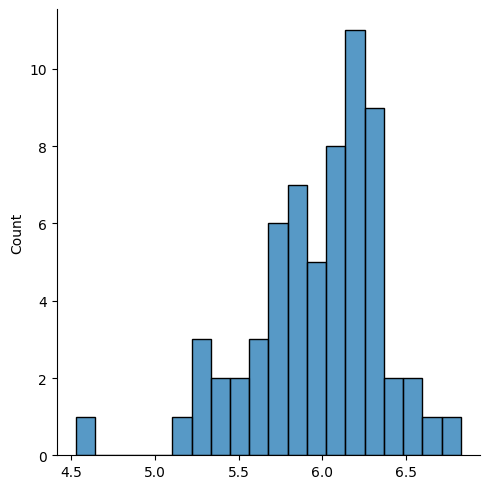

In [25]:
sns.displot(val[:, 0], bins=20);

### Gradient

In [27]:
%time acsf.grad(s, atom_index=0)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.95 ms


Array([[-6.27212702e-02,  8.80951822e-02, -1.56816984e-01],
       [-4.62278074e-02,  9.10051630e-02, -1.36374852e-01],
       [ 8.97642271e-05, -3.30828609e-04,  4.09431819e-05],
       [-1.42030746e-04, -3.42536373e-06,  1.29556699e-05],
       [-1.42030746e-04, -3.42536373e-06,  1.29556699e-05]],      dtype=float64)

## Scaler

Descriptor scaler.

In [28]:
from jaxip.descriptors.scaler import DescriptorScaler

### Fitting scaling parameters

In [29]:
scaler = DescriptorScaler(scale_type='scale_center')
# acsf = nnp.descriptor["H"]

for structure in tqdm(structures):
    x = acsf(structure)
    scaler.fit(x)

scaler

100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0)

In [30]:
scaled_x = []
for structure in tqdm(structures):
    x = acsf(structure)
    scaled_x.append(scaler(x))

scaled_x = jnp.concatenate(scaled_x, axis=0)
scaled_x.shape

100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


(640, 5)

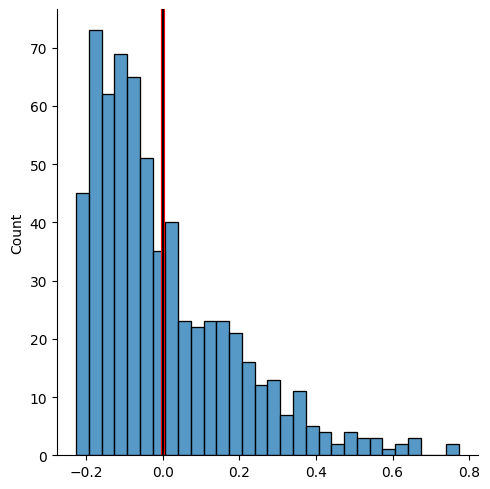

In [31]:
sx = scaled_x[:, 5]
sns.displot(sx, bins=30)
plt.axvline(sx.mean(), color='r', lw=3);
plt.axvline(0, color='k');

## Model

In [32]:
from jaxip.models.nn import NeuralNetworkModel
from jaxip.models.initializer import UniformInitializer
from flax import linen as nn

In [33]:
nn = NeuralNetworkModel(
    hidden_layers=((8, 'tanh'), (8, 'tanh')),
    kernel_initializer=UniformInitializer(weights_range=(-1, 1)),
    # param_dtype=jnp.float64,
)

nn

NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), output_layer=(1, 'identity'))

In [34]:
rng = jax.random.PRNGKey(2022)                       # PRNG Key
x = jnp.ones(shape=(8, acsf.num_symmetry_functions)) # Dummy Input
params = nn.init(rng, x)                             # Initialize the parameters
jax.tree_map(lambda x: x.shape, params)              # Check the parameters

FrozenDict({
    params: {
        layers_0: {
            bias: (8,),
            kernel: (5, 8),
        },
        layers_2: {
            bias: (8,),
            kernel: (8, 8),
        },
        layers_4: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})

### Computing output energy

In [35]:
energies = nn.apply(params, scaled_x[:, :])

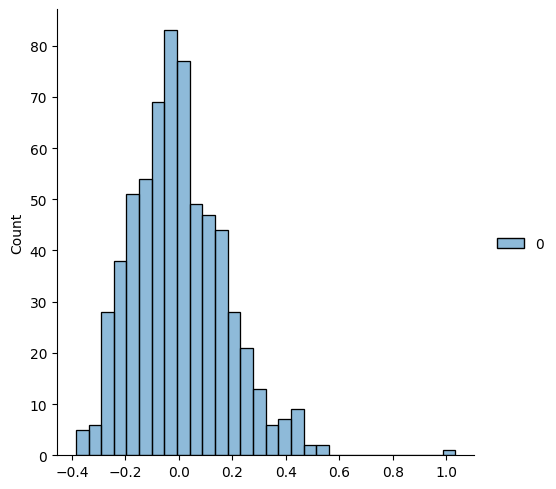

In [36]:
sns.displot(energies, bins=30);

## Atomic Potential

An atomic potential calculates the energy of a specific element in structures. It forms the basic building block of the final potential, which typically contains multiple elements. Atomic potential bundles up all the necessary components such as descriptors, scalers, and models in order to output the per-atomic energy.

In [37]:
from jaxip.potentials.nnp import AtomicPotential

In [38]:
atomic_potential = AtomicPotential(
    descriptor=acsf,
    scaler=scaler,
    model=nn,
)

atomic_potential

AtomicPotential(
  descriptor=ACSF(element='O', num_symmetry_functions=5, r_cutoff=12.0),
  scaler=DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0),
  model=NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), output_layer=(1, 'identity')),
)

In [40]:
out =  atomic_potential.apply(params["params"], s)
out.shape

(64, 1)

In [41]:
energies = []
for structure in tqdm(structures):
    out = atomic_potential.apply(params['params'], structure)
    energies.append(out)

energies = jnp.concatenate(energies, axis=0)
energies.shape

100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


(640, 1)

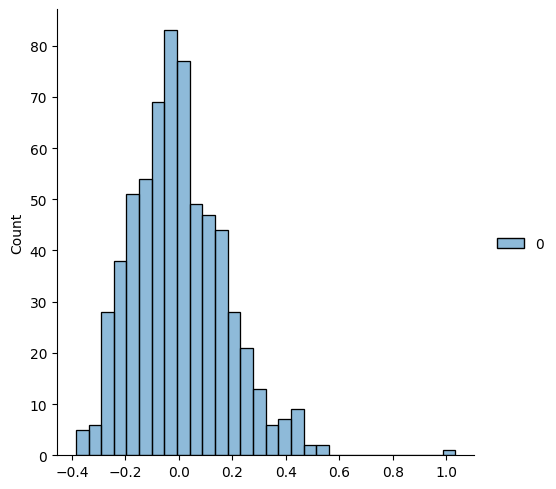

In [42]:
sns.displot(energies, bins=30);

Please note that the above graph is exactly the same graph as we obtained before by using the model.

## Neural Network Potential

An instance of neural network potential (NNP) including descirptor, scaler, and model for multiple elements can be initialzied directly from the input potential files. 

In [43]:
from jaxip.datasets import RunnerStructureDataset
from jaxip.potentials import NeuralNetworkPotential
from ase.visualize import view

### Read dataset

In [46]:
base_dir = Path("GRN")

# Atomic data
structures = RunnerStructureDataset(Path(base_dir, "input.data"))

# structures = [structures[i] for i in range(10)]
structure = structures[0]
structure

Structure(natoms=24, elements=('C',), dtype=float64)

In [47]:
view(structure.to_ase_atoms() * (3, 3, 2), viewer='x3d')

### Load potential parameters

In [48]:
# Potential
nnp = NeuralNetworkPotential.create_from(Path(base_dir, "input.nn"))

# nnp.save()
nnp.load()

### Predictions

Warm-up period can usually be attributed to lazy class loading and just-in-time compilation.

In [53]:
%time total_energy = nnp(structure)
total_energy

CPU times: user 34.4 ms, sys: 197 µs, total: 34.6 ms
Wall time: 33.9 ms


Array(-8.15190098, dtype=float64)

In [54]:
%time force = nnp.compute_force(structure)
force

CPU times: user 52.9 ms, sys: 77 µs, total: 53 ms
Wall time: 50.9 ms


{'C': Array([[-4.18090155e-02, -1.27078119e-04, -9.72108961e-03],
        [-2.81391607e-02,  6.94367425e-03, -2.49789995e-03],
        [-5.73216900e-03,  2.12257858e-02,  1.90822649e-02],
        [-5.88424600e-02,  5.81628250e-02,  7.85566227e-03],
        [ 3.75029529e-02, -2.73450235e-02,  4.34703226e-03],
        [-3.37732854e-02, -5.27282665e-02, -1.16930585e-02],
        [-4.46842867e-02,  1.45532186e-03, -1.65656895e-03],
        [ 6.48994249e-02,  9.39972161e-03, -1.38110354e-02],
        [-5.49760520e-02, -1.71988088e-02,  8.51288426e-03],
        [-1.22060833e-02,  1.72540668e-02, -7.97985204e-03],
        [-1.58684166e-02, -3.15420241e-02,  1.62903193e-02],
        [ 3.80699898e-02, -9.93323387e-03,  6.09660649e-03],
        [ 7.93777031e-03, -2.73686743e-03, -2.64380293e-03],
        [ 2.24468900e-02,  2.72967796e-02, -1.54639272e-03],
        [ 2.76843985e-02, -1.21141076e-02,  1.29106877e-02],
        [ 4.15975776e-03,  3.97966561e-02, -1.37619952e-02],
        [ 4.5975355